In [1]:
import argparse
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms
import pickle as pk

### Arguments

In [2]:
subject = 'F'
layer = 1
context_length = 1
noreg = False
voxels_options = ['ALL', 'ALLROI', 'POSTTEMP', 'ANTTEMP', 'ANGULARG', 'IFG', 'MFG', 'IFGORB', 'PCINGULATE', 'DMPFC']
voxels_type = 'ALLROI'

In [3]:
def get_X_Y(metrics1, metrics2, subject, voxels_type):
    X = np.nanmean(metrics1, axis=0)
    Y = np.nanmean(metrics2, axis=0)

    X[np.where(np.isnan(X) == 1)] = 0
    Y[np.where(np.isnan(Y) == 1)] = 0

    rois = np.load('../HP_subj_roi_inds.npy', allow_pickle=True)

    if voxels_type != 'ALL':
        X = X[np.where(rois.item()[subject]['all'] == 1)[0]]
        Y = Y[np.where(rois.item()[subject]['all'] == 1)[0]]
        if voxels_type != 'ALLROI':
            if voxels_type == 'POSTTEMP':
                mask = rois.item()[subject]['PostTemp'][np.where(rois.item()[subject]['all'] > 0)[0]]
            elif voxels_type == 'ANTTEMP':
                mask = rois.item()[subject]['AntTemp'][np.where(rois.item()[subject]['all'] > 0)[0]]
            elif voxels_type == 'ANGULARG':
                mask = rois.item()[subject]['AngularG'][np.where(rois.item()[subject]['all'] > 0)[0]]
            elif voxels_type == 'IFG':
                mask = rois.item()[subject]['IFG'][np.where(rois.item()[subject]['all'] > 0)[0]]
            elif voxels_type == 'MFG':
                mask = rois.item()[subject]['MFG'][np.where(rois.item()[subject]['all'] > 0)[0]]
            elif voxels_type == 'IFGORB':
                mask = rois.item()[subject]['IFGorb'][np.where(rois.item()[subject]['all'] > 0)[0]]
            elif voxels_type == 'PCINGULATE':
                mask = rois.item()[subject]['pCingulate'][np.where(rois.item()[subject]['all'] > 0)[0]]
            elif voxels_type == 'DMPFC':
                mask = rois.item()[subject]['dmpfc'][np.where(rois.item()[subject]['all'] > 0)[0]]
            X = np.ma.masked_equal(mask * X, 0).compressed()
            Y = np.ma.masked_equal(mask * Y, 0).compressed()
    return X, Y

# Correlation Plots

In [ ]:
model1 = 'linear'
model2 = 'linear_sgd'
if noreg:
    model1 += '_noreg'
    model2 += '_noreg'
else:
    model1 += '_reg'
    model2 += '_reg'

In [ ]:
output_path = 'encoder_preds/maxvoxels/predict_{}_with_bert_layer_{}_len_{}_encoder_{}.npy'
output1 = np.load(output_path.format(subject, layer, context_length, model1), allow_pickle=True)
output2 = np.load(output_path.format(subject, layer, context_length, model2), allow_pickle=True)
corrs1 = output1.item()['corrs_t']
corrs2 = output2.item()['corrs_t']

In [ ]:
# Best Fit Line
# def plot_accuracies(X, Y, subject, voxels_type, x_label, y_label):
#     plt.scatter(X, Y)
#     f = np.poly1d(np.polyfit(X, Y, 1))
#     print("BFL Coefficients: {}".format(f.c))
#     plt.plot(X, f(X), color='black')
#     plt.plot(np.array([0., 1.]), np.array([0., 1.]), color='red')
#     plt.title('Corrs BFL: Sub={}, Layer={}, Context={}, Voxels={} \n {} v {}'.format(subject, layer, context_length, voxels_type, x_label, y_label))
#     plt.xlabel(xlab)
#     plt.ylabel(ylab)
#     plt.xlim(-0.25, 0.5)
#     plt.ylim(-0.25, 0.5)
#     plt.gca().set_aspect('equal', adjustable='box')
#     plt.show()

In [ ]:
# PCA
from sklearn.decomposition import PCA
def plot_correlations(X, Y, subject, voxels_type, x_label, y_label):
    plt.scatter(X, Y)
    
    pca = PCA(n_components=1, svd_solver='full')
    pca_first = pca.fit(np.transpose(np.vstack([X,Y])))
    x_mean, y_mean = np.mean(X), np.mean(Y)
    plt.plot((-1,1),(-1,1),'r')
    print("PCA comps: {}".format(pca_first.components_[0]))
    plt.plot((x_mean-pca_first.components_[0][0],x_mean,x_mean+pca_first.components_[0][0]),(y_mean-pca_first.components_[0][1], y_mean, y_mean+pca_first.components_[0][1]), 'k')
    
    plt.title('Corrs PCA: Sub={}, Layer={}, Context={}, Voxels={} \n {} v {}'.format(subject, layer, context_length, voxels_type, x_label, y_label))
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.xlim(-0.25, 0.5)
    plt.ylim(-0.25, 0.5)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()   

In [ ]:
X, Y = get_X_Y(corrs1, corrs2, subject, voxels_type)

In [ ]:
plot_correlations(X, Y, subject, voxels_type, model1, model2)

# Accuracy Plots

In [4]:
model1 = 'linear'
model2 = 'linear_sklearn'
if noreg:
    model1 += '_noreg'
    model2 += '_noreg'
else:
    model1 += '_reg'
    model2 += '_reg'
acc_type = 'noneighborhood' # or 'neighborhood'

In [7]:
accs_path = 'final_accs/maxvoxels/{}/{}_with_bert_layer_{}_len_{}_encoder_{}_accs.pkl'
accs1 = pk.load(open(accs_path.format(acc_type, subject, layer, context_length, model1), 'rb'))
accs2 = pk.load(open(accs_path.format(acc_type, subject, layer, context_length, model2), 'rb'))

In [ ]:
# Best Fit Line
# def plot_accuracies(X, Y, subject, voxels_type, x_label, y_label):
#     plt.scatter(X, Y)
#     f = np.poly1d(np.polyfit(X, Y, 1))
#     print("BFL Coefficients: {}".format(f.c))
#     plt.plot(X, f(X), color='black')
#     plt.plot(np.array([0., 1.]), np.array([0., 1.]), color='red')
#     plt.title('Accs BFL: Sub={}, Layer={}, Context={}, Voxels={} \n {} v {}'.format(subject, layer, context_length, voxels_type, x_label, y_label))
#     plt.xlabel(x_label)
#     plt.ylabel(y_label)
#     plt.xlim(0, 1)
#     plt.ylim(0, 1)
#     plt.gca().set_aspect('equal', adjustable='box')
#     plt.show()

In [8]:
# PCA
from sklearn.decomposition import PCA
def plot_accuracies(X, Y, subject, voxels_type, x_label, y_label):
    plt.scatter(X, Y)
    
    pca = PCA(n_components=1, svd_solver='full')
    pca_first = pca.fit(np.transpose(np.vstack([X,Y])))
    x_mean, y_mean = np.mean(X), np.mean(Y)
    plt.plot((0,1),(0,1),'r')
    print("PCA comps: {}".format(pca_first.components_[0]))
    plt.plot((x_mean-pca_first.components_[0][0],x_mean,x_mean+pca_first.components_[0][0]),(y_mean-pca_first.components_[0][1], y_mean, y_mean+pca_first.components_[0][1]), 'k')
    
    plt.title('Accs PCA: Sub={}, Layer={}, Context={}, Voxels={} \n {} v {}'.format(subject, layer, context_length, voxels_type, x_label, y_label))
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()    
    

In [9]:
X, Y = get_X_Y(accs1, accs2, subject, voxels_type)

PCA comps: [-0.70712434 -0.70708923]


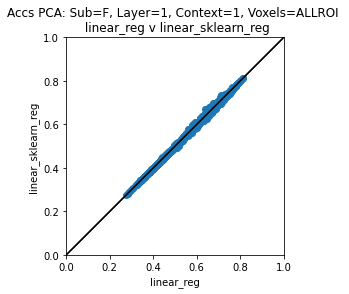

In [10]:
plot_accuracies(X, Y, subject, voxels_type, model1, model2)

## Synthetic Data Experiments

Start with 20 datapoints using BFL formula

##### No Noise

In [ ]:
X1 = np.random.rand(20)
# X1 = np.random.uniform(0.4, 0.8, 20)
Y1 = 0.8*X1 + 0.1
X, Y = X1, Y1

In [ ]:
plot_accuracies(X, Y, 'Synthetic', '20', '0', 'None')

In [ ]:
plot_accuracies(Y, X, 'Synthetic-Swapped', '20', '0', 'None')

##### With Noise

Added 50 noisy points with noise ~ N(0, 0.1)

In [ ]:
X2 = np.random.rand(50)
# X2 = np.random.uniform(0.4, 0.8, 50)
Y2_original = (0.8*X2 + 0.1)
noise = np.random.normal(0, 0.1, X2.shape)
Y2 = Y2_original + noise
np.putmask(Y2, Y2 >= 1.0, 1.0)
X, Y = np.concatenate((X1, X2)), np.concatenate((Y1, Y2))

In [ ]:
plot_accuracies(X, Y, 'Synthetic', '20', '50', 'N(0, 0.1)')

In [ ]:
plot_accuracies(Y, X, 'Synthetic-Swapped', '20', '50', 'N(0, 0.1)')

Added 50 noisy points with noise ~ N(0, 0.2)

In [ ]:
X2 = np.random.rand(50)
# X2 = np.random.uniform(0.4, 0.8, 50)
Y2_original = (0.8*X2 + 0.1)
noise = np.random.normal(0, 0.2, X2.shape)
Y2 = Y2_original + noise
np.putmask(Y2, Y2 >= 1.0, 1.0)
X, Y = np.concatenate((X1, X2)), np.concatenate((Y1, Y2))

In [ ]:
plot_accuracies(X, Y, 'Synthetic', '20', '50', 'N(0, 0.2)')

In [ ]:
plot_accuracies(Y, X, 'Synthetic-Swapped', '20', '50', 'N(0, 0.2)')